### Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# for nlp part

import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [25]:
# for cv part

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras.backend as K
from keras.models import load_model

In [26]:
# for multimodal part

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

### Functions

In [3]:
# show the metrics of a model

def get_metrics(y_val, y_pred, pos_label):
    print(confusion_matrix(y_val, y_pred))
    print(f'accuracy = {accuracy_score(y_val, y_pred)}')
    print(f'F1 score = {f1_score(y_val, y_pred, pos_label=pos_label)}')
    print(f'precision = {precision_score(y_val, y_pred, pos_label=pos_label)}')
    print(f'recall = {recall_score(y_val, y_pred, pos_label=pos_label)}')

### Import dataset

The original dataset 'padchest_pneumonia_normal_en.csv' was provided by Wafa and conteins reports translated by Google Translator as well as ChatGPT.

The dataset was splitted on training, validation and test parts in a separate notebook.

In [19]:
train_set = pd.read_csv('./drive/MyDrive/Colab/MMML/training_set.csv', low_memory=False)
val_set = pd.read_csv('./drive/MyDrive/Colab/MMML/validation_set.csv', low_memory=False)
test_set = pd.read_csv('./drive/MyDrive/Colab/MMML/test_set.csv', low_memory=False)

In [ ]:
train_set.shape

(5761, 17)

In [ ]:
train_set.head(3)

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,102109826991700169491794009328257401163_yk55tc...,20170508,102109826991700169491794009328257401163,80342194608282024804381685221733578164,1970.0,M,POSTEROANTERIOR,5377371,NO,sin hallazg relev,Physician,normal,[],[['normal']],47.0,"""no relevant findings""",no relevant finding
1,16195291732581043929483414230565603291-3_tkvs1...,20171106,16195291732581043929483414230565603291-3,254654689860114856846890774049753268092,1997.0,M,POSTEROANTERIOR,5510015,NO,resolucion practic complet neumotorax derech ...,Physician,normal,"['loc right', 'loc left', 'loc hemithorax']","[['normal', 'loc right'], ['normal', 'loc hemi...",20.0,"Translated text: ""Practical resolution complet...",complete practical resolution right pneumothor...
2,224317221325445520926245339017025976472_lzt2je...,20160118,224317221325445520926245339017025976472,5138157077994189375543509304304176478,1984.0,M,LATERAL,5063109,NO,sin hallazg relev,Physician,normal,[],[['normal']],32.0,"""no relevant findings""",no relevant finding


In [ ]:
val_set.shape

(1017, 17)

In [ ]:
test_set.shape

(1197, 17)

In [20]:
# split labels

def split_labels(df):
    df['normal'] = df['Labels'].map(lambda x: 1. if str(x) == 'normal' else 0.)
    df['pneumonia'] = df['Labels'].map(lambda x: 1. if str(x) == 'pneumonia' else 0.)
    return df

In [21]:
train_set = split_labels(train_set)
val_set = split_labels(val_set)
test_set = split_labels(test_set)

In [ ]:
# check classes size

def classes_size(df, dataset_part):
    df_normal = df[df['Labels']=='normal'].shape
    df_pneumonia = df[df['Labels']=='pneumonia'].shape
    print(f'{df_normal} normal labels and {df_pneumonia} pneumonia labels in {dataset_part}')

In [ ]:
classes_size(train_set, 'training')
classes_size(val_set, 'validation')
classes_size(test_set, 'test')

(5394, 19) normal labels and (367, 19) pneumonia labels in training
(944, 19) normal labels and (73, 19) pneumonia labels in validation
(1114, 19) normal labels and (83, 19) pneumonia labels in test


In [ ]:
# this function checks data leakage of the dataset, and was originally developed by Saurabh Bhardwaj

def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs

    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    df1_patients_unique = df1[patient_col].nunique()
    df2_patients_unique = df2[patient_col].nunique()

    patients_in_both_groups = df1_patients_unique+df2_patients_unique

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(list(set(df1[patient_col].values).intersection(set(df2[patient_col].values)))) > 0 # boolean (true if there is at least 1 patient in both groups)

    ### END CODE HERE ###

    return leakage

In [ ]:
# check data leakage between training, validation and test part by PatientID

print("leakage between train and valid: {}".format(check_for_leakage(train_set, val_set, 'PatientID')))
print("leakage between train and test: {}".format(check_for_leakage(train_set, test_set, 'PatientID')))
print("leakage between valid and test: {}".format(check_for_leakage(val_set, test_set, 'PatientID')))

leakage between train and valid: True
leakage between train and test: True
leakage between valid and test: True


### NLP

#### Preprocessing

In [33]:
# normilize

train_set['Report_en_ChatGPT'] = train_set['Report_en_ChatGPT'].str.lower()
val_set['Report_en_ChatGPT'] = val_set['Report_en_ChatGPT'].str.lower()
test_set['Report_en_ChatGPT'] = test_set['Report_en_ChatGPT'].str.lower()

In [34]:
# this function was originally developed by Wafa

# remove extra symbols and comments from ChatGPT

def pre_process(text):
    sentences = re.findall(r'"(.*?)"', text)
    if len(sentences)==0:
        return(text)
    elif len(sentences) >= 2:
        second_sentence = sentences[1]
        return(second_sentence)
    else:
        return(sentences[0])

In [35]:
train_set['Report_en_ChatGPT'] = train_set['Report_en_ChatGPT'].apply(lambda x : pre_process(x))
val_set['Report_en_ChatGPT'] = val_set['Report_en_ChatGPT'].apply(lambda x : pre_process(x))
test_set['Report_en_ChatGPT'] = test_set['Report_en_ChatGPT'].apply(lambda x : pre_process(x))

In [36]:
# remove stop words

tokenizer = RegexpTokenizer(r'\w+')
ps = PorterStemmer()
detokenizer = TreebankWordDetokenizer()

nltk.download('stopwords')
stop=stopwords.words('english')
stop.remove('no')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
# we remove stop words from training part, but leave validation and test untouchable

train_set['Report_en_ChatGPT'] = train_set['Report_en_ChatGPT'].map(lambda x: tokenizer.tokenize(str(x)))
train_set['Report_en_ChatGPT'] = train_set['Report_en_ChatGPT'].map(lambda x: \
                                                                          [ps.stem(word) for word in x if not word in stop])
train_set['Report_en_ChatGPT'] = train_set['Report_en_ChatGPT'].map(lambda x: detokenizer.detokenize(x))
train_set['Report_en_ChatGPT']

0                                           no relev find
1       practic resolut complet no signific patholog f...
2                                           no relev find
3                                           no relev find
4                                           no relev find
                              ...                        
5756                                        no relev find
5757                       without signific patholog find
5758    no identifi imag consolid opac lung no signifi...
5759                 no observ infiltr without relev find
5760                         no patholog find patient age
Name: Report_en_ChatGPT, Length: 5761, dtype: object

In [38]:
train_corpus_model = train_set['Report_en_ChatGPT'].values
train_corpus_model

array(['no relev find',
       'practic resolut complet no signific patholog find right pneumothorax left hemithorax show signific patholog find',
       'no relev find', ...,
       'no identifi imag consolid opac lung no signific entiti within normal limit cardiac mediastinum silhouett',
       'no observ infiltr without relev find',
       'no patholog find patient age'], dtype=object)

In [39]:
val_corpus_model = val_set['Report_en_ChatGPT'].values

In [40]:
test_corpus_model = test_set['Report_en_ChatGPT'].values

In [42]:
# create the Bag of Words model

vectorizer = CountVectorizer()

X_train_nlp = vectorizer.fit_transform(train_corpus_model).toarray()
y_train_nlp = train_set['Labels'].values

X_val_nlp = vectorizer.transform(val_corpus_model).toarray()
y_val_nlp = val_set['Labels'].values

X_test_nlp = vectorizer.transform(test_corpus_model).toarray()
y_test_nlp = test_set['Labels'].values

#### Model Building

In [61]:
# train the Naive Bayes (NB) model on the training set

nb_classifier = GaussianNB()
nb_classifier.fit(X_train_nlp, y_train_nlp)

GaussianNB()

In [56]:
# train the Support Vector Machine (SVM) model on the training set

svm_classifier = SVC()
svm_classifier.fit(X_train_nlp, y_train_nlp)

SVC()

#### Prediction and the model evaluation

In [63]:
# predict the validation set results, NB

y_pred_nlp_nb = nb_classifier.predict(X_val_nlp)

result_nlp_nb = {'y_val': y_val_nlp, 'y_pred': y_pred_nlp_nb}
df_result_nlp_nb = pd.DataFrame(result_nlp_nb)
df_result_nlp_nb

,y_val,y_pred
0,normal,normal
1,normal,normal
2,normal,normal
3,normal,normal
4,normal,normal
...,...,...
1012,normal,normal
1013,normal,normal
1014,normal,normal
1015,normal,normal


In [62]:
# predict the validation set results, SVM

y_pred_nlp_svm = svm_classifier.predict(X_val_nlp)

result_nlp_svm = {'y_val': y_val_nlp, 'y_pred': y_pred_nlp_svm}
df_result_nlp_svm = pd.DataFrame(result_nlp_svm)
df_result_nlp_svm

,y_val,y_pred
0,normal,normal
1,normal,normal
2,normal,normal
3,normal,normal
4,normal,normal
...,...,...
1012,normal,normal
1013,normal,normal
1014,normal,normal
1015,normal,normal


In [64]:
# calculate the metrics, NB

get_metrics(y_val_nlp, y_pred_nlp_nb, "pneumonia")

[[927  17]
 [  6  67]]
accuracy = 0.9773844641101278
F1 score = 0.8535031847133758
precision = 0.7976190476190477
recall = 0.9178082191780822


False positive rate equals 17, and the model predicted 'pneumonia' for patients who actually did not have pneumonia.

False negative rate equals 6, and the model predicted 'normal' for patients who actually had pneumonia. This is a critical metric for our case that is more important than false positive rate.

The F1 score is 0.8535, and expresses the dependency between precision and recall. Precision shows how many patients who were defined with pneumonia actually have pneumonia while recall shows how many patients with pneumonia the model defined.

In [65]:
# calculate the metrics, SVM

get_metrics(y_val_nlp, y_pred_nlp_svm, "pneumonia")

[[942   2]
 [ 23  50]]
accuracy = 0.9754178957718781
F1 score = 0.7999999999999999
precision = 0.9615384615384616
recall = 0.684931506849315


In [66]:
# choose NB, because it has lower false negative rate

y_pred_nlp = y_pred_nlp_nb

### CV

#### Preprocessing

In [27]:
labels = ['normal', 'pneumonia']

In [28]:
# this block was constructed with the tutorial developed by Saurabh Bhardwaj

#image_directory = "images/pneumonia_normal_images"
image_height = 224
image_width = 224

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,  # Define your preprocess_image function here
    rescale=1.0/255.0,  # Normalize pixel values
)

# Create TensorFlow generators for training and validation
batch_size = 32

train_generator = datagen.flow_from_dataframe(
    dataframe=train_set,
    directory="./drive/MyDrive/Colab/MMML/pneumonia_normal_images/training_set",
    x_col='ImageID',
    y_col=labels,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_set,
    directory="./drive/MyDrive/Colab/MMML/pneumonia_normal_images/validation_set",
    x_col='ImageID',
    y_col=labels,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_set,
    directory="./drive/MyDrive/Colab/MMML/pneumonia_normal_images/test_set",
    x_col='ImageID',
    y_col=labels,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

Found 5761 validated image filenames.
Found 1017 validated image filenames.
Found 1197 validated image filenames.


#### Dealing with class imbalance

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # total number of patients (rows)
    N = len(labels)

    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = 1 - positive_frequencies

    #freq_pos = np.array([freq_pos, freq_neg])

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.93629578, 0.06370422])

In [ ]:
freq_neg

array([0.06370422, 0.93629578])

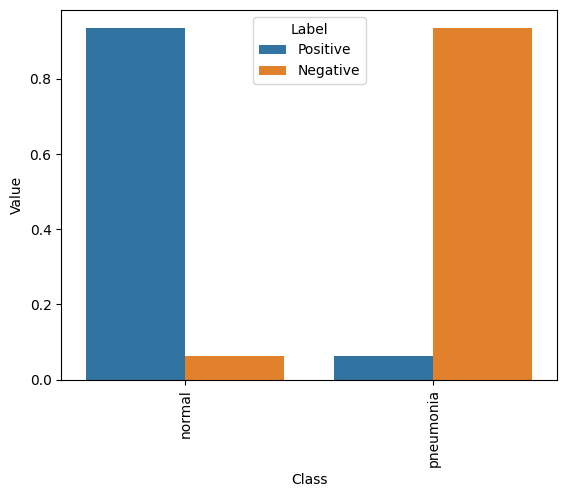

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
#data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

data = pd.concat([data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])])
plt.xticks(rotation=90)


f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

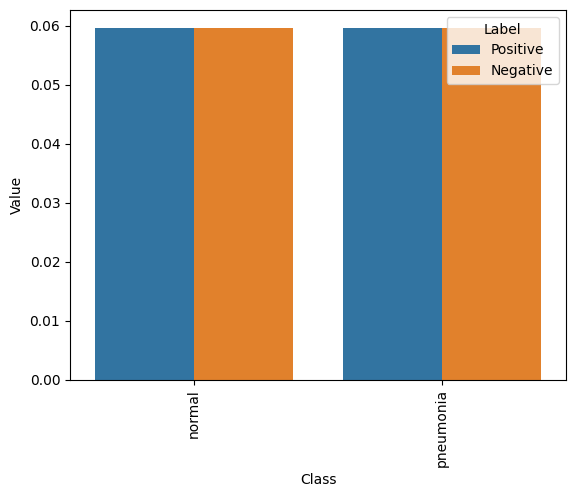

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
#data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
#                         for l,v in enumerate(neg_contribution)], ignore_index=True)

data = pd.concat([data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)])])
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss += K.mean(-(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon)
                            + neg_weights[i] * (1 - y_true[:, i]) * K.log((1 - y_pred[:, i]) + epsilon))) #complete this line
        return loss

        ### END CODE HERE ###
    return weighted_loss

#### Model Building

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(include_top=False) # weights='./drive/MyDrive/Colab/MMML/densenet.hdf5'
x = base_model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='./drive/MyDrive/Colab/MMML/best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
# Train the model
hist = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
181/181 [==============================] - 2777s 15s/step - loss: 0.1702 - accuracy: 0.5831 - val_loss: 0.2024 - val_accuracy: 0.4435
Epoch 2/10
181/181 [==============================] - 2524s 14s/step - loss: 0.1649 - accuracy: 0.5966 - val_loss: 0.1965 - val_accuracy: 0.3491
Epoch 3/10
181/181 [==============================] - 2537s 14s/step - loss: 0.1689 - accuracy: 0.5619 - val_loss: 0.3583 - val_accuracy: 0.1121
Epoch 4/10
181/181 [==============================] - 2545s 14s/step - loss: 0.1627 - accuracy: 0.6830 - val_loss: 0.4561 - val_accuracy: 0.2163
Epoch 5/10
181/181 [==============================] - 2537s 14s/step - loss: 0.1604 - accuracy: 0.6738 - val_loss: 0.6389 - val_accuracy: 0.3687
Epoch 6/10
181/181 [==============================] - 2490s 14s/step - loss: 0.1629 - accuracy: 0.7004 - val_loss: 0.2216 - val_accuracy: 0.3894
Epoch 7/10
181/181 [==============================] - 2532s 14s/step - loss: 0.1625 - accuracy: 0.6749 - val_loss: 0.1705 - val_ac

In [ ]:
# save the model for further investigation

model.save('./drive/MyDrive/Colab/MMML/DenseNet121')

In [ ]:
# load the saved model
# (failed because of custom loss...)

DenseNet121 = tf.keras.models.load_model('./drive/MyDrive/Colab/MMML/DenseNet121')

In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

32/32 [==============================] - 94s 3s/step - loss: 0.1644 - accuracy: 0.5978
Validation Loss: 0.1644, Validation Accuracy: 0.5978


#### Prediction and the model evaluation

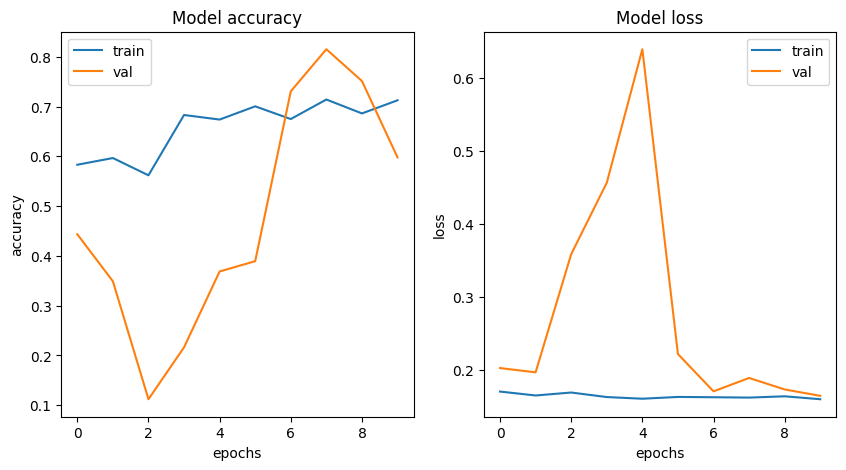

In [ ]:
# plot accuracy and loss through epochs

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])

    ax[i].set_title('Model {}'.format(met))

    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)

    ax[i].legend(['train', 'val'])

Validation loss has a strong outlier and then decreases. It would be good to try more epoches that can improve the situation.

In [ ]:
# predict the validation set results

predicted_vals = model.predict_generator(val_generator, steps = len(val_generator))
predicted_vals

<ipython-input-35-5ce178b15daf>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(val_generator, steps = len(val_generator))


array([[0.45683655, 0.53500867],
       [0.0973497 , 0.9154546 ],
       [0.39836875, 0.5969562 ],
       ...,
       [0.5739042 , 0.4164264 ],
       [0.571588  , 0.41852394],
       [0.45435458, 0.544991  ]], dtype=float32)

In [ ]:
# save the predictions to process it further
np.save('./drive/MyDrive/Colab/MMML/densenet121_predicted_vals', predicted_vals)

In [4]:
predicted_vals = np.load('./drive/MyDrive/Colab/MMML/densenet121_predicted_vals.npy')

In [16]:
# we have two elements (normal and pneumonia) and have to tranform the array:
#if the second element is grater than 0.5, it is pneumonia because the second column is pneumonia labels

y_pred_cv = np.where(predicted_vals[:,1] > 0.5, 'pneumonia', 'normal').reshape(-1,1)
y_pred_cv

array([['pneumonia'],
       ['pneumonia'],
       ['pneumonia'],
       ...,
       ['normal'],
       ['normal'],
       ['pneumonia']], dtype='<U9')

In [31]:
y_val_cv = val_set['Labels'].values.reshape(-1,1)
y_val_cv

array([['normal'],
       ['normal'],
       ['normal'],
       ...,
       ['normal'],
       ['normal'],
       ['normal']], dtype=object)

In [32]:
# calculate the metrics

get_metrics(y_val_cv, y_pred_cv, "pneumonia")

[[573 371]
 [ 31  42]]
accuracy = 0.6047197640117994
F1 score = 0.1728395061728395
precision = 0.1016949152542373
recall = 0.5753424657534246


False positive rate equals 371, and the model predicted 'pneumonia' for patients who actually did not have pneumonia.

False negative rate equals 31, and the model predicted 'normal' for patients who actually had pneumonia. This is a critical metric for our case that is more important than false positive rate.

It seems that adding more epoches for training can improve the results.

### Multimodal, Late Fusion

In [46]:
# Obtain individual predictions

text_predictions = y_pred_nlp
image_predictions = y_pred_cv

In [47]:
# y_val

Y = val_set['Labels'].values.reshape(-1,1)
Y

array([['normal'],
       ['normal'],
       ['normal'],
       ...,
       ['normal'],
       ['normal'],
       ['normal']], dtype=object)

In [48]:
# Use a classifier for fusion

fusion_classifier = RandomForestClassifier()

In [49]:
# fusion classifier requires numeric values instead of text
# therefore we transform the values by LabelEncoder

le = LabelEncoder()

In [50]:
# Stack predictions for late fusion

stacked_predictions = np.column_stack((le.fit_transform(text_predictions), le.fit_transform(image_predictions)))
stacked_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 0],
       [0, 0],
       [0, 1]])

In [51]:
Y = le.fit_transform(Y).reshape(-1,1)
Y

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [52]:
# train the fusion classifier

fusion_classifier.fit(stacked_predictions, Y) # Y is the target label

<ipython-input-52-015e375bef61>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fusion_classifier.fit(stacked_predictions, Y) # Y is the target label


RandomForestClassifier()

In [53]:
# predict the validation set results

final_predictions = fusion_classifier.predict(stacked_predictions)

In [54]:
# calculate the metrics

get_metrics(Y, final_predictions, 1)

[[927  17]
 [  6  67]]
accuracy = 0.9773844641101278
F1 score = 0.8535031847133758
precision = 0.7976190476190477
recall = 0.9178082191780822


The metrics values repeat the nlp model results. It seems that the fusion part selected the best result between two models - nlp and computer vision.